In [1]:
library(Seurat)
library(dplyr)

library(ggplot2)
library(ggh4x)
library(ggrepel)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Data load

In [2]:
load('../data/commons.rda', verbose = T)

Loading objects:
  cell.type.colors
  cell.types
  cell.types.nohighmito
  chr_df
  donor_sex
  fig
  flora_paper_list
  gene_type.df
  imprinted.df
  imprinted.genes
  monkey_paper_list
  monkey.genes
  monkey.markers
  nescreg.genes
  nescreg.genes.no_trg
  nescreg.genes.no_trg.early
  nescreg.list
  nescreg.list.no_trg
  nescreg.list.no_trg.early
  nescreg.markers
  nescreg.markers.no_trg
  nescreg.markers.no_trg.early
  nicola_marker_list
  origin_sex.colors
  pat.de
  pat.de.top20
  pat.list
  pat.neu.de
  pat.neu.de.top20
  pat.neu.list
  pat.neu.top20
  pat.top20
  phases
  phases.colors
  protein_coding.genes
  region.genes
  region.list
  region.markers
  samples
  samples.colors
  sex_chr.genes
  sex_chr.genes.x
  sex_chr.genes.y
  shown_2b_list
  shown_4d_list
  tf.genes
  tfs.df
  top100.sub.pat
  top100.subtype
  valid_chr


In [3]:
today.dir <- glue::glue('../plots/VennDonors_{Sys.Date()}/')

dir.create(today.dir)

In [4]:
int.levels <- c( 'D8_ASD_375&D8_ASD_384&D8_ASD_494', 'D8_ASD_375&D8_ASD_384', 'D8_ASD_375&D8_ASD_494', 'D8_ASD_384&D8_ASD_494', 'D8_ASD_375', 'D8_ASD_384', 'D8_ASD_494')

crossed.res <- data.table::fread('../results/selected_markers/markers_per_donor.nohighmito.with_filters_and_crossed.csv', data.table=F, drop = 1) %>% 
    mutate(
        anno_cluster_fct = factor(anno_cluster_fct, cell.types.nohighmito),
        matching.donors = factor(matching.donors, int.levels))
crossed.sub <- subset(crossed.res, filter.over.max)
crossed.sub.no_sex <- subset(crossed.res, filter.over.max & !in.sex_chr)
crossed.sub.no_sex.tf_only <- subset(crossed.res, filter.over.max & !in.sex_chr & gene.is.tf)

### Supplementary table 9

In [8]:
dfs <- list()
subset(crossed.res, !in.sex_chr) %>% 

    mutate(Up.in.ASD.or.control = plyr::mapvalues(sign(avg_log2FC), from=c(-1,0,1), to=c('Control', 'None', 'ASD'))) %>%

    arrange(anno_cluster_fct, Up.in.ASD.or.control, desc(abs(avg_log2FC))) %>%

    select(
        gene, anno_cluster_fct, donor, Up.in.ASD.or.control, avg_log2FC, p_val, p_val_adj,
        ident.1, ncells.1, pct.1,
        ident.2, ncells.2, pct.2, 
        max.cells.per.ident, filter.over.max,
        gene.is.tf, gene_biotype,
        Imprinted.Status, Expressed.Allele)  %>% 
    mutate(anno_cluster_fct = plyr::mapvalues(anno_cluster_fct, from='FGF17-like', to='PC FGF17-like'),
           donor = plyr::mapvalues(donor, from='D8_ASD_494', to='D8_ASD_434'))-> dfs$`Individual DEGs`

dfs$`Individual DEGs` %>% subset((p_val_adj <= 0.05) & filter.over.max) -> dfs$`Filtered individual DEGs`



openxlsx::write.xlsx(x = dfs, file = '../results/supp_table.9.per_donor_DEGs.xlsx')

### Exportable

In [6]:
exptbl <- unique(crossed.sub[,c('overexpressed.in', 'gene', 'anno_cluster_fct', 'matching.donors', 'gene.is.tf', 'in.sex_chr')]) %>%arrange_all()
split(exptbl, exptbl$`overexpressed.in`) ->exptbls

exptbls <- c(
    exptbls,
    lapply(exptbls, subset, !in.sex_chr & gene.is.tf) %>% setNames(paste(names(exptbls), 'TFs not sex_chr')),
    lapply(exptbls, subset, !in.sex_chr & gene.is.tf & anno_cluster_fct=='RG early') %>% setNames(paste('RGE', names(exptbls), 'TFs not sex_chr'))
)

In [7]:
subset(exptbls$Ctrl, anno_cluster_fct == 'Mes prog') %>% subset(matching.donors == 'D8_ASD_375&D8_ASD_384')

,overexpressed.in,gene,anno_cluster_fct,matching.donors,gene.is.tf,in.sex_chr
,<chr>,<chr>,<fct>,<fct>,<lgl>,<lgl>
380,Ctrl,IGDCC3,Mes prog,D8_ASD_375&D8_ASD_384,FALSE,FALSE


In [8]:
lapply(exptbls, reframe, unique(gene)) %>% lapply(unlist) %>% lapply(unname)

$ASD
  [1] "ACTA2"           "ADGRL3"          "ALDH2"           "AP2S1"          
  [5] "ARL2"            "ATP1A2"          "BAALC"           "BBLN"           
  [9] "C4orf48"         "CA4"             "CAMK2N1"         "CARHSP1"        
 [13] "CCK"             "CCND1"           "CD151"           "CD24"           
 [17] "CD99"            "CDH11"           "CHCHD2"          "CKB"            
 [21] "CLU"             "COL2A1"          "COTL1"           "CPE"            
 [25] "CPNE1"           "CRABP1"          "CRABP2"          "CRIP1"          
 [29] "CSRP2"           "DDIT4"           "DDX3Y"           "DLK1"           
 [33] "DRD4"            "DSTN"            "EIF1AY"          "EIF4EBP1"       
 [37] "EMX2"            "ENSG00000261586" "ENSG00000272449" "ENSG00000276345"
 [41] "ENSG00000289474" "EVA1B"           "FBLN1"           "FGF8"           
 [45] "FGFR2"           "FJX1"            "FN1"             "FOXG1"          
 [49] "FRZB"            "FZD5"            "GCNT1"           "H1-1"           
 [53] "H19"             "HES1"            "HES4"            "HES5"           
 [57] "HLA-C"           "HLA-DPB1"        "HSPA1A"          "ID2"            
 [61] "ID4"             "IDH2"            "IFITM2"          "IFITM3"         
 [65] "IGDCC3"          "IGF2"            "IGFBP3"          "IGFBP5"         
 [69] "IRX3"            "KCNK12"          "KRT19"           "L1TD1"          
 [73] "LAMP5"           "LDHA"            "LFNG"            "LGALS1"         
 [77] "LHX2"            "LHX5-AS1"        "LIMCH1"          "LINC01896"      
 [81] "LINC02609"       "LRP2"            "MAP3K13"         "MEG3"           
 [85] "MEG8"            "MEIS2"           "METRN"           "MGST1"          
 [89] "MIR219A2HG"      "MUSTN1"          "MYL9"            "NR6A1"          
 [93] "NREP"            "NRIP3"           "NTRK2"           "NXPH4"          
 [97] "PAFAH1B3"        "PAMR1"           "PANTR1"          "PAX8-AS1"       
[101] "PDLIM1"          "PDLIM7"          "PEG10"           "PEG3"           
[105] "PHOX2B"          "PITX2"           "PKM"             "PMEL"           
[109] "POU3F2"          "PPP1R14A"        "PPP1R1A"         "PRDX5"          
[113] "PRMT2"           "PRSS23"          "PSAT1"           "PTN"            
[117] "PURPL"           "RAB11FIP1"       "RBFOX2"          "RBMX"           
[121] "RBP1"            "RFX4"            "RPS10"           "RPS4Y1"         
[125] "SEMA5A"          "SFRP1"           "SFRP2"           "SIX3"           
[129] "SLC3A2"          "SLC7A11"         "SOX4"            "SPEGNB"         
[133] "SPRY1"           "TAGLN"           "TAL2"            "TBCA"           
[137] "TIMM10"          "TMEM147"         "TMSB10"          "TMSB15A"        
[141] "TNNT1"           "TOMM7"           "TOX3"            "TPI1"           
[145] "TPM1"            "TPM2"            "TTYH1"           "UBXN4"          
[149] "UCHL1"           "UPP1"            "USP9Y"           "VAX2"           
[153] "VPS28"           "WNT7B"           "XACT"            "ZNF528-AS1"     
[157] "ZNF667-AS1"      "ZNF703"         

$Ctrl
  [1] "ACTA2"           "ACTC1"           "ALDH2"           "APOE"           
  [5] "ARF5"            "ARPC3"           "ARX"             "ATP6V1G1"       
  [9] "BASP1"           "BTF3"            "BTG2"            "C1QBP"          
 [13] "CACHD1"          "CCDC144NL-AS1"   "CCT2"            "CCT5"           
 [17] "CEMIP2"          "CFAP298"         "CHASERR"         "CHCHD2"         
 [21] "COTL1"           "CRABP1"          "CSTB"            "CYCS"           
 [25] "DDX18"           "DDX21"           "DDX46"           "DLK1"           
 [29] "DMRTA1"          "DNAJC15"         "DRD4"            "EGLN3"          
 [33] "EGR1"            "EID1"            "EIF3E"           "EIF5B"          
 [37] "ELP5"            "EMX2"            "ENSG00000289474" "ENSG00000289901"
 [41] "ENY2"            "ERH"             "FEZF1"           "FEZF1-AS1"      
 [45] "FEZF2"           "FILIP1"          "FOX

In [9]:
lapply(exptbls, reframe, unique(gene)) %>% lapply(nrow) %>% print()

$ASD
[1] 158

$Ctrl
[1] 138

$`ASD TFs not sex_chr`
[1] 19

$`Ctrl TFs not sex_chr`
[1] 20

$`RGE ASD TFs not sex_chr`
[1] 11

$`RGE Ctrl TFs not sex_chr`
[1] 12



In [10]:
openxlsx::write.xlsx(x = exptbls, file = '../results/selected_markers/markers_per_donor.nohighmito.with_filters_and_crossed.simple.xlsx')


### EDA summaries

In [11]:
split.res <- split(crossed.sub.no_sex, apply(crossed.sub.no_sex[,c('anno_cluster_fct', 'overexpressed.in', 'matching.donors')], 1, paste, collapse=': '))
# split(crossed.sub.no_sex$gene, apply(crossed.sub.no_sex[,c('anno_cluster_fct', 'overexpressed.in', 'donor')], 1, paste, collapse=': '))

In [12]:
# summary
message('All genes')

with(unique(crossed.res[,c('gene', 'matching.donors', 'overexpressed.in', 'anno_cluster_fct')]),
{table(donors = matching.donors, 
      `overexpressed in` = overexpressed.in,
      `cell type` = anno_cluster_fct)})

All genes



, , cell type = FGF17-like

                                  overexpressed in
donors                             ASD Ctrl None
  D8_ASD_375&D8_ASD_384&D8_ASD_494   0    0    0
  D8_ASD_375&D8_ASD_384              0    0    0
  D8_ASD_375&D8_ASD_494              0    0    0
  D8_ASD_384&D8_ASD_494              0    0    0
  D8_ASD_375                         0    1    0
  D8_ASD_384                         6    1    0
  D8_ASD_494                         0    0    0

, , cell type = Mes prog

                                  overexpressed in
donors                             ASD Ctrl None
  D8_ASD_375&D8_ASD_384&D8_ASD_494   2    0    0
  D8_ASD_375&D8_ASD_384              2    1    0
  D8_ASD_375&D8_ASD_494              0    1    0
  D8_ASD_384&D8_ASD_494              3   15    0
  D8_ASD_375                         8    3    0
  D8_ASD_384                        29   10    0
  D8_ASD_494                        27   52    0

, , cell type = RG early

                                

In [13]:
message('Not in X/Y chromosomes')
with(unique(subset(crossed.res, !in.sex_chr)[,c('gene', 'matching.donors', 'overexpressed.in', 'anno_cluster_fct')]),
{table(donors = matching.donors, 
      `overexpressed in` = overexpressed.in,
      `cell type` = anno_cluster_fct)})

Not in X/Y chromosomes



, , cell type = FGF17-like

                                  overexpressed in
donors                             ASD Ctrl None
  D8_ASD_375&D8_ASD_384&D8_ASD_494   0    0    0
  D8_ASD_375&D8_ASD_384              0    0    0
  D8_ASD_375&D8_ASD_494              0    0    0
  D8_ASD_384&D8_ASD_494              0    0    0
  D8_ASD_375                         0    1    0
  D8_ASD_384                         6    1    0
  D8_ASD_494                         0    0    0

, , cell type = Mes prog

                                  overexpressed in
donors                             ASD Ctrl None
  D8_ASD_375&D8_ASD_384&D8_ASD_494   1    0    0
  D8_ASD_375&D8_ASD_384              2    1    0
  D8_ASD_375&D8_ASD_494              0    1    0
  D8_ASD_384&D8_ASD_494              3   14    0
  D8_ASD_375                         8    3    0
  D8_ASD_384                        29   10    0
  D8_ASD_494                        26   50    0

, , cell type = RG early

                                

In [14]:
message('TFs (Not in X/Y chromosomes)')
with(unique(subset(crossed.res, gene.is.tf & !in.sex_chr)[,c('gene', 'matching.donors', 'overexpressed.in', 'anno_cluster_fct')]),
{table(donors = matching.donors, 
      `overexpressed in` = overexpressed.in,
      `cell type` = anno_cluster_fct)})

TFs (Not in X/Y chromosomes)



, , cell type = FGF17-like

                                  overexpressed in
donors                             ASD Ctrl None
  D8_ASD_375&D8_ASD_384&D8_ASD_494   0    0    0
  D8_ASD_375&D8_ASD_384              0    0    0
  D8_ASD_375&D8_ASD_494              0    0    0
  D8_ASD_384&D8_ASD_494              0    0    0
  D8_ASD_375                         0    0    0
  D8_ASD_384                         1    0    0
  D8_ASD_494                         0    0    0

, , cell type = Mes prog

                                  overexpressed in
donors                             ASD Ctrl None
  D8_ASD_375&D8_ASD_384&D8_ASD_494   0    0    0
  D8_ASD_375&D8_ASD_384              0    0    0
  D8_ASD_375&D8_ASD_494              0    0    0
  D8_ASD_384&D8_ASD_494              0    2    0
  D8_ASD_375                         0    1    0
  D8_ASD_384                         2    2    0
  D8_ASD_494                         7    4    0

, , cell type = RG early

                                

# Functions 

## build intersections

In [15]:
split(crossed.sub.no_sex.tf_only$gene, crossed.sub.no_sex.tf_only$anno_cluster_fct)%>%lapply(unique)%>%lapply(length)

$`FGF17-like`
[1] 1

$`Mes prog`
[1] 17

$`RG early`
[1] 23

$`RG late`
[1] 14

$`Neral crest/Mes`
[1] 2

$Neuron
[1] 6

In [16]:
length(unique(crossed.sub.no_sex.tf_only$gene))

[1] 35

In [17]:
get_presence_table <- function(sets){
    
    elements <- unlist(sets)%>%unique()
    int.tbl <- lapply(sets, function(x){elements%in%x})%>%do.call(what='cbind')%>%as.data.frame()
    rownames(int.tbl) <- elements
    return(int.tbl)
}

In [18]:
get_intersections <- function(bool_tbl, return.as='list'){
    
    int.stat <- apply(bool_tbl, 1, function(x){colnames(bool_tbl)[x]%>% paste(collapse='&')})
    if (return.as == 'data.frame'){
        return(cbind(bool_tbl, int.stat)%>%as.data.frame())
    } else if (return.as=='table') {
        return(table(int.stat))
    } else if (return.as == 'list'){
        int.sets <- split(rownames(bool_tbl), int.stat)
        return(int.sets)
    }
}

In [19]:
genes_to_string <- function(genes, sep=', ', return_sep='\n', return_every=5){
    
    added <- c()
    i <- 0
    
    for (g in genes){
        if (i == return_every){
            added <- c(added,return_sep)
            i <- 0
        }
        added <- c(added, g, sep)
        i <- i + 1
    }
    added <- head(added, n = -1)
    return(paste0(added, collapse=''))
}

In [20]:
print.list <- function(int.tbl){
    
    require(glue)
    # split list in shared by all, by 2 or restricted
    
    # count number of &
    n.ds <- lengths(regmatches(names(int.tbl), gregexpr("&", names(int.tbl))))
    

    
    if (!any(n.ds==2)){
        all.str <- '-> No DEGs shared by all donors\n'
    } else {
        all.genes <- int.tbl[[which(n.ds==2)]]
        all.str <- paste0('-> ', length(all.genes), ' DEGs shared by ALL donors:\n\t',
                          genes_to_string(all.genes, return_sep='\n\t'), '\n')
    }

    
    if (!any(n.ds==1)){
        shared.str <- '-> No DEGs shared by only 2 donors\n'
    } else {
        
        shareds <- int.tbl[which(n.ds==1)]
        shared.str <- ''
        
        for (sh in names(shareds)){
            sh.genes <- shareds[[sh]]
            shared.str <- paste0(shared.str, '-> ', length(sh.genes), ' DEGs shared by ', 
                                 gsub(sh, pattern="&", replacement=" & "), ':\n\t', 
                                 genes_to_string(sh.genes, return_sep='\n\t'), '\n')
        }
    }
    
        
    if (!any(n.ds==0)){
        restricted.str <- '-> No DEGs restricted to only 1 donor\n'
    } else {
        
        restricteds <- int.tbl[which(n.ds==0)]
        restricted.str <- ''
        
        for (sh in names(restricteds)){
            restricted.genes <- restricteds[[sh]]
            restricted.str <- paste0(restricted.str, '-> ', length(restricted.genes), ' DEGs in ', sh, ':\n\t', 
                                     genes_to_string(restricted.genes, return_sep='\n\t'), '\n')
        }
    }
    
    
    summary.str <- paste(all.str, shared.str, restricted.str, sep='\n')
    
    cat(summary.str )
    
    return(summary.str)
    
}

In [21]:
inters.table2 <- function(int.tbl, middle_all=T){

    int.levels<- c('D8_ASD_375&D8_ASD_384&D8_ASD_494', 'D8_ASD_375&D8_ASD_494', 'D8_ASD_375&D8_ASD_384', 'D8_ASD_384&D8_ASD_494', 'D8_ASD_375', 'D8_ASD_384', 'D8_ASD_494')
    
    lapply(int.levels, function(x){
        if(!x %in% names(int.tbl)){0}else{length(int.tbl[[x]])}}) %>% setNames(int.levels) -> int.fulltbl
    # int.fulltbl <- list(2,4,2,4,1,3,5) %>% setNames(int.levels)

    data.frame(int.fulltbl)%>%t()%>%as.data.frame() %>% rename(n=V1) %>% 
    mutate(
        int.label = int.levels,
        comb.group = sapply(strsplit(int.levels, split='&', fixed=T), length))-> int.pdf
    if (middle_all){
        int.pdf$comb.group <- abs(int.pdf$comb.group-4)
    }
    int.pdf %>% group_by(comb.group) %>% mutate(
        # n.id = (seq_along(along.with = n)-1),
        ymax = cumsum(rep(1, length.out = length(n))/length(n)),
        ymin = c(0, head(ymax, n=-1)),
        xmin = comb.group,
        xmax = xmin+((n)/max(max(n),1))
    ) %>% ungroup ()  %>% mutate(
        xmax.abs = xmin+(n/max(n)),
        ylabel = (ymax + ymin) / 2,
        xlabel = comb.group+0.5
    )-> int.pdf

    int.pdf[(int.pdf['comb.group']==2),c('ymin', 'ymax', 'ylabel')] <- int.pdf[(int.pdf['comb.group']==2),c('ymin', 'ymax', 'ylabel')]-1/6
    int.pdf.rot <- int.pdf[(int.pdf['ymin']<0),]
    
    int.pdf.rot[, 'ymax'] <- 1
    int.pdf.rot[, 'ymin'] <- int.pdf.rot[, 'ymin']+1
    int.pdf.rot$xlabel <- NA
    int.pdf.rot$ylabel <- NA
    int.pdf[(int.pdf['ymin']<0), 'ymin'] <- 0
    return(rbind(int.pdf, int.pdf.rot))
}


In [30]:
donors  <- samples[samples%in%crossed.res$donor]

donors.pal <- setNames(
    c(1/3, 2/3, 3/3),
    # paste0(samples.colors[donors], '88'), 
    donors)

# Make the plot
library(ggh4x)
fig(20,10)

int.colors <- c('darkgrey', 'yellow', 'violet', 'cyan', 'red','green', 'blue') %>%setNames(int.levels)
vcolors <- hcl(donors.pal[colnames(bool.tbl)] * 360, 130, 60)

In [84]:
rep.fname <- glue::glue('{today.dir}Venns_no_sex_chromosome_genes.txt')
cairo_pdf(glue::glue('{today.dir}Venns_no_sex_chromosome_genes.pdf'), height=10, width=10, onefile=T)

int.summaries <- ''
int.venns <- list()
ints.tbl2 <- list()

for (bias in c('ASD', 'Ctrl')){
# for (bias in c('ASD')){

    int.venns[[bias]] <- list()
    int.summaries <- paste0(int.summaries, '##########\n## ', bias, ' ##\n##########\n\n')

    for (ct in unique(cell.types.nohighmito)){
    # for (ct in c('Mes prog')){
    
        
        group <- paste0('Up in ', bias, ': ',  ct)
        message(group)
        
        this.res <- subset(crossed.sub.no_sex, (overexpressed.in == bias) & (anno_cluster_fct == ct))
        d.split <- split(this.res$gene, this.res$donor)
        
        bool.tbl <- get_presence_table(d.split)
        int.tbl <- get_intersections(bool.tbl, return.as = 'list')
        int.tbl <- int.tbl[int.levels[int.levels%in%names(int.tbl)]]
        
        ints.tbl2 <- c(ints.tbl2, list(inters.table2(int.tbl) %>%mutate(CT=ct, BIAS=bias)))

        summarised <- print.list(int.tbl)

        # parameter <- par(mfrow=c(1,2))
        
        if ((length(int.tbl) > 1) & any(grepl(pattern='&', x=names(int.tbl), fixed=T))){
            message('\tplotting')
            vd <- venneuler::venneuler(bool.tbl)
            vd$colors <- donors.pal[names(vd$colors)]
            # vd$diameters <- vd$diameters*0.97
            int.venns[[bias]][[ct]] <- vd
            parameter <- plot(vd)
        } else {
            plot.new()
        }
        mtext(group)
        
        # text(0,1, summarised, adj=c(0,1), cex = .7)    
        venn::venn(bool.tbl, ilabels='counts', box = F, ggplot = T,ilcs = 2, sncs = 1.5,
           zcolor = vcolors, col = 'black') -> ggvd
        
        plot.new()+mtext(group)+plot(newpage = F, ggvd)
        summarised <- paste0('### ', group, '\n\n', summarised, '\n\n')
        int.summaries <- paste0(int.summaries, summarised)
        
        print('')
        print(grep('&', names(int.tbl), fixed=T, value=T))
       
    }
}
dev.off()

cat(int.summaries, file = rep.fname)

ints.tbl2 <- ints.tbl2 %>% do.call(what='rbind')

Up in ASD: FGF17-like



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 6 DEGs in D8_ASD_384:
	CSRP2, FGF8, FZD5, SFRP1, SIX3, 
	SPRY1
[1] ""
character(0)


Up in ASD: Mes prog



-> 1 DEGs shared by ALL donors:
	MEG3

-> 2 DEGs shared by D8_ASD_375 & D8_ASD_384:
	TAGLN, ZNF528-AS1
-> 3 DEGs shared by D8_ASD_384 & D8_ASD_494:
	COL2A1, NREP, PTN

-> 8 DEGs in D8_ASD_375:
	ACTA2, CARHSP1, FBLN1, KRT19, LDHA, 
	MEG8, TIMM10, TNNT1
-> 29 DEGs in D8_ASD_384:
	ADGRL3, CCK, CPE, CSRP2, DDIT4, 
	DLK1, ENSG00000276345, FJX1, FOXG1, FZD5, 
	ID2, IFITM3, IGFBP3, IGFBP5, LAMP5, 
	LRP2, PAFAH1B3, PDLIM7, PRSS23, RAB11FIP1, 
	RBFOX2, RBP1, RPS10, SEMA5A, SIX3, 
	SLC7A11, SPRY1, VPS28, ZNF667-AS1
-> 26 DEGs in D8_ASD_494:
	BAALC, CAMK2N1, CD24, CRABP1, CRABP2, 
	CRIP1, ENSG00000272449, EVA1B, FN1, H19, 
	HES5, IGDCC3, IGF2, IRX3, LIMCH1, 
	MEIS2, MIR219A2HG, MUSTN1, NTRK2, PAX8-AS1, 
	PDLIM1, PHOX2B, POU3F2, PPP1R1A, RFX4, 
	ZNF703


	plotting



[1] ""
[1] "D8_ASD_375&D8_ASD_384&D8_ASD_494" "D8_ASD_375&D8_ASD_384"           
[3] "D8_ASD_384&D8_ASD_494"           


Up in ASD: RG early



-> No DEGs shared by all donors

-> 5 DEGs shared by D8_ASD_375 & D8_ASD_384:
	CSRP2, H1-1, KRT19, MEG3, ZNF528-AS1
-> 3 DEGs shared by D8_ASD_384 & D8_ASD_494:
	COL2A1, PDLIM7, RPS10

-> 5 DEGs in D8_ASD_375:
	CARHSP1, LDHA, MEG8, TIMM10, TNNT1
-> 49 DEGs in D8_ASD_384:
	ACTA2, ATP1A2, CCK, CCND1, CD24, 
	CDH11, COTL1, CPE, CRABP1, DDIT4, 
	DLK1, EIF4EBP1, ENSG00000276345, FBLN1, FJX1, 
	FOXG1, FRZB, FZD5, HES1, ID2, 
	IFITM2, IFITM3, IGFBP3, IGFBP5, L1TD1, 
	LAMP5, LHX2, LRP2, MEIS2, MGST1, 
	NREP, PAFAH1B3, PRSS23, PSAT1, PTN, 
	RAB11FIP1, RBP1, SEMA5A, SIX3, SLC7A11, 
	SOX4, SPRY1, TAGLN, TAL2, TPM1, 
	TPM2, UPP1, VAX2, VPS28
-> 13 DEGs in D8_ASD_494:
	ARL2, C4orf48, CRIP1, ENSG00000272449, HES4, 
	HES5, IGDCC3, LHX5-AS1, NR6A1, PAX8-AS1, 
	PEG10, TTYH1, WNT7B


	plotting



[1] ""
[1] "D8_ASD_375&D8_ASD_384" "D8_ASD_384&D8_ASD_494"


Up in ASD: RG late



-> No DEGs shared by all donors

-> 3 DEGs shared by D8_ASD_375 & D8_ASD_384:
	CSRP2, KRT19, ZNF528-AS1
-> 6 DEGs shared by D8_ASD_384 & D8_ASD_494:
	AP2S1, COL2A1, CPE, HLA-C, MYL9, 
	RPS10

-> 9 DEGs in D8_ASD_375:
	ALDH2, CA4, CARHSP1, ENSG00000289474, LGALS1, 
	MEG3, TIMM10, TNNT1, UBXN4
-> 53 DEGs in D8_ASD_384:
	ATP1A2, CCK, CCND1, CD24, CDH11, 
	COTL1, CRABP1, DDIT4, DLK1, EIF4EBP1, 
	ENSG00000276345, FBLN1, FJX1, FOXG1, FRZB, 
	FZD5, HES1, HSPA1A, ID2, IDH2, 
	IFITM2, IFITM3, IGFBP3, IGFBP5, KCNK12, 
	L1TD1, LAMP5, LHX2, MAP3K13, MEIS2, 
	METRN, MGST1, MUSTN1, NREP, PAFAH1B3, 
	PAMR1, PMEL, PRDX5, PTN, PURPL, 
	RBP1, SEMA5A, SFRP1, SFRP2, SIX3, 
	SLC3A2, SPRY1, TAGLN, TAL2, TMSB10, 
	TPM1, UCHL1, VPS28
-> 29 DEGs in D8_ASD_494:
	BBLN, C4orf48, CD151, CKB, CLU, 
	CPNE1, CRIP1, DRD4, DSTN, EMX2, 
	ENSG00000272449, FGFR2, GCNT1, HES5, HLA-DPB1, 
	ID4, IGDCC3, LFNG, LHX5-AS1, LINC01896, 
	LINC02609, NRIP3, PAX8-AS1, PRMT2, TBCA, 
	TOMM7, TOX3, TTYH1, WNT7B


	plotting



[1] ""
[1] "D8_ASD_375&D8_ASD_384" "D8_ASD_384&D8_ASD_494"


Up in ASD: Neral crest/Mes



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 5 DEGs in D8_ASD_494:
	CHCHD2, CRIP1, LDHA, PEG3, TMEM147
[1] ""
character(0)


Up in ASD: Neuron



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 1 DEGs in D8_ASD_375:
	MEG3
-> 11 DEGs in D8_ASD_494:
	ENSG00000261586, HES4, HES5, NXPH4, PANTR1, 
	PAX8-AS1, PITX2, PKM, PPP1R14A, SPEGNB, 
	TPI1
[1] ""
character(0)


Up in Ctrl: FGF17-like



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 1 DEGs in D8_ASD_375:
	NNAT
-> 1 DEGs in D8_ASD_384:
	WLS
[1] ""
character(0)


Up in Ctrl: Mes prog



-> No DEGs shared by all donors

-> 1 DEGs shared by D8_ASD_375 & D8_ASD_384:
	IGDCC3
-> 1 DEGs shared by D8_ASD_375 & D8_ASD_494:
	NNAT
-> 14 DEGs shared by D8_ASD_384 & D8_ASD_494:
	APOE, ARPC3, C1QBP, DMRTA1, EIF5B, 
	H1-5, MT-ATP8, PDCD5, PFDN2, RANBP1, 
	SNRPF, TPBG, UBE2C, YBX3

-> 3 DEGs in D8_ASD_375:
	CHCHD2, GABPB1-AS1, PEG3
-> 10 DEGs in D8_ASD_384:
	CCDC144NL-AS1, FEZF2, HSP90B1, LDHA, LFNG, 
	LHX5-AS1, NOS2, NR2F2, SLIRP, WLS
-> 50 DEGs in D8_ASD_494:
	ACTA2, ACTC1, ALDH2, CCT2, CCT5, 
	COTL1, CSTB, CYCS, DDX18, DDX21, 
	DLK1, DNAJC15, ELP5, ERH, FEZF1-AS1, 
	FILIP1, GJA1, GNG10, GNL3, GTF2A2, 
	H1-3, HSPE1, ID4, IFITM3, JUND, 
	LAPTM4A, LMAN1, MYL12A, NDUFC2, NEXN, 
	NOL7, OAZ1, ODC1, POU3F1, PRSS23, 
	PSIP1, RCN2, SF3B6, SIX3, SMC4, 
	SNRNP40, SRI, SSB, STRAP, SUMO1, 
	TOP1, TPM1, UBE2S, VCL, ZNF22


	plotting



[1] ""
[1] "D8_ASD_375&D8_ASD_384" "D8_ASD_375&D8_ASD_494" "D8_ASD_384&D8_ASD_494"


Up in Ctrl: RG early



-> No DEGs shared by all donors

-> 2 DEGs shared by D8_ASD_375 & D8_ASD_384:
	GABPB1-AS1, IGDCC3
-> 1 DEGs shared by D8_ASD_384 & D8_ASD_494:
	MT-ATP8

-> 4 DEGs in D8_ASD_375:
	CHCHD2, CRABP1, NNAT, PEG3
-> 31 DEGs in D8_ASD_384:
	ALDH2, APOE, BASP1, CACHD1, CCDC144NL-AS1, 
	CEMIP2, DMRTA1, EGR1, EMX2, FEZF2, 
	FOXB1, ID4, LAPTM4A, LFNG, LHX5-AS1, 
	MIAT, NOS2, NRIP3, PAX6, PIAS1, 
	POU3F2, SALL4, SEMA3A, SESN3, SULF1, 
	TLE1, TPBG, TRIM24, WLS, ZFP36L2, 
	ZNF503
-> 12 DEGs in D8_ASD_494:
	DLK1, DNAJC15, ENSG00000289901, FEZF1-AS1, HNRNPA3, 
	IFITM3, PRSS23, RANBP1, RAX, RCN2, 
	SNRPF, YBX3


	plotting



[1] ""
[1] "D8_ASD_375&D8_ASD_384" "D8_ASD_384&D8_ASD_494"


Up in Ctrl: RG late



-> No DEGs shared by all donors

-> 1 DEGs shared by D8_ASD_384 & D8_ASD_494:
	ARF5

-> 2 DEGs in D8_ASD_375:
	CHCHD2, NNAT
-> 24 DEGs in D8_ASD_384:
	ALDH2, APOE, CACHD1, CCDC144NL-AS1, CEMIP2, 
	DMRTA1, DRD4, EGLN3, EMX2, FOXB1, 
	ID4, IGDCC3, LFNG, LHX5-AS1, MT-ATP8, 
	NOS2, NRIP3, PAX6, PFDN2, POU3F2, 
	TLE1, TPBG, WLS, ZFP36L2
-> 12 DEGs in D8_ASD_494:
	DLK1, DNAJC15, FEZF1-AS1, IFITM3, MGST1, 
	RAX, RCN2, SIX3, SPINT2, UBE2C, 
	UBE2S, YBX3


	plotting



[1] ""
[1] "D8_ASD_384&D8_ASD_494"


Up in Ctrl: Neral crest/Mes



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 12 DEGs in D8_ASD_494:
	BTF3, DDX21, ENY2, HNRNPF, NR2F1, 
	PCBP1, PPIG, PSIP1, SEC62, SRSF9, 
	STRAP, TOP1
[1] ""
character(0)


Up in Ctrl: Neuron



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 2 DEGs in D8_ASD_375:
	CHCHD2, NNAT
-> 29 DEGs in D8_ASD_494:
	ARPC3, ATP6V1G1, BTG2, CFAP298, CHASERR, 
	COTL1, CSTB, DDX46, DLK1, DNAJC15, 
	EID1, EIF3E, ENSG00000289474, FEZF1, GLUL, 
	MT-ATP8, PABPN1, PRSS23, PSMA6, RCN2, 
	RPS27L, SEC61G, SNHG5, SNRPF, SOX2, 
	STRAP, TPBG, VIM, YBX3
[1] ""
character(0)


png 
  2

In [30]:
pdf(glue::glue('{today.dir}Pies_no_sex_chromosome_genes.pdf'), height=10, width=20)

ggplot(ints.tbl2, aes(ymax=ymax, ymin=ymin, xmax=xmax.abs, xmin=xmin, 
                    fill=factor(int.label, rev(int.levels)))) +
    geom_rect(color='black', linewidth=0.1) +
    geom_vline(xintercept = 1, color='#FFFFFF22') + 
    geom_vline(xintercept = 2, color='#FFFFFF22') + 
    geom_vline(xintercept = 3, color='#FFFFFF22') + 
    geom_vline(xintercept = 4, color='#FFFFFF22') + 
    facet_nested(cols=vars(factor(CT, cell.types.nohighmito)), rows=vars(factor(BIAS, c('ASD', 'Ctrl'))), switch='y') + 
    geom_label(aes(y=ylabel, x=ifelse(xlabel<1.5, 1.5, xlabel),
                  color=int.label,
                  # label=ifelse(n==0, NA, n)), 
                  label=n), 
               # alpha=0.7,
               fontface='bold', 
               size=4) + # x here controls label position (inner / outer)
    scale_fill_manual('Lines', values=int.colors) +
    scale_color_manual(values=ifelse(int.colors=='blue', 'lightgray', 'black'), guide = guide_none()) +
    coord_polar(theta="y") +
    xlim(c(-.5, 4)) +
    theme_void()  +
    theme(panel.border = element_rect(fill='transparent', color='#00000099'),
        strip.text = element_text(size=15),
        strip.background = element_rect(fill='#00000022'))

dev.off()

Up in ASD: FGF17-like



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 6 DEGs in D8_ASD_384:
	CSRP2, FGF8, FZD5, SFRP1, SIX3, 
	SPRY1


Up in ASD: Mes prog



-> 1 DEGs shared by ALL donors:
	MEG3

-> 2 DEGs shared by D8_ASD_375 & D8_ASD_384:
	TAGLN, ZNF528-AS1
-> 3 DEGs shared by D8_ASD_384 & D8_ASD_494:
	COL2A1, NREP, PTN

-> 8 DEGs in D8_ASD_375:
	ACTA2, CARHSP1, FBLN1, KRT19, LDHA, 
	MEG8, TIMM10, TNNT1
-> 29 DEGs in D8_ASD_384:
	ADGRL3, CCK, CPE, CSRP2, DDIT4, 
	DLK1, ENSG00000276345, FJX1, FOXG1, FZD5, 
	ID2, IFITM3, IGFBP3, IGFBP5, LAMP5, 
	LRP2, PAFAH1B3, PDLIM7, PRSS23, RAB11FIP1, 
	RBFOX2, RBP1, RPS10, SEMA5A, SIX3, 
	SLC7A11, SPRY1, VPS28, ZNF667-AS1
-> 26 DEGs in D8_ASD_494:
	BAALC, CAMK2N1, CD24, CRABP1, CRABP2, 
	CRIP1, ENSG00000272449, EVA1B, FN1, H19, 
	HES5, IGDCC3, IGF2, IRX3, LIMCH1, 
	MEIS2, MIR219A2HG, MUSTN1, NTRK2, PAX8-AS1, 
	PDLIM1, PHOX2B, POU3F2, PPP1R1A, RFX4, 
	ZNF703


Up in ASD: RG early



-> No DEGs shared by all donors

-> 5 DEGs shared by D8_ASD_375 & D8_ASD_384:
	CSRP2, H1-1, KRT19, MEG3, ZNF528-AS1
-> 3 DEGs shared by D8_ASD_384 & D8_ASD_494:
	COL2A1, PDLIM7, RPS10

-> 5 DEGs in D8_ASD_375:
	CARHSP1, LDHA, MEG8, TIMM10, TNNT1
-> 49 DEGs in D8_ASD_384:
	ACTA2, ATP1A2, CCK, CCND1, CD24, 
	CDH11, COTL1, CPE, CRABP1, DDIT4, 
	DLK1, EIF4EBP1, ENSG00000276345, FBLN1, FJX1, 
	FOXG1, FRZB, FZD5, HES1, ID2, 
	IFITM2, IFITM3, IGFBP3, IGFBP5, L1TD1, 
	LAMP5, LHX2, LRP2, MEIS2, MGST1, 
	NREP, PAFAH1B3, PRSS23, PSAT1, PTN, 
	RAB11FIP1, RBP1, SEMA5A, SIX3, SLC7A11, 
	SOX4, SPRY1, TAGLN, TAL2, TPM1, 
	TPM2, UPP1, VAX2, VPS28
-> 13 DEGs in D8_ASD_494:
	ARL2, C4orf48, CRIP1, ENSG00000272449, HES4, 
	HES5, IGDCC3, LHX5-AS1, NR6A1, PAX8-AS1, 
	PEG10, TTYH1, WNT7B


Up in ASD: RG late



-> No DEGs shared by all donors

-> 3 DEGs shared by D8_ASD_375 & D8_ASD_384:
	CSRP2, KRT19, ZNF528-AS1
-> 6 DEGs shared by D8_ASD_384 & D8_ASD_494:
	AP2S1, COL2A1, CPE, HLA-C, MYL9, 
	RPS10

-> 9 DEGs in D8_ASD_375:
	ALDH2, CA4, CARHSP1, ENSG00000289474, LGALS1, 
	MEG3, TIMM10, TNNT1, UBXN4
-> 53 DEGs in D8_ASD_384:
	ATP1A2, CCK, CCND1, CD24, CDH11, 
	COTL1, CRABP1, DDIT4, DLK1, EIF4EBP1, 
	ENSG00000276345, FBLN1, FJX1, FOXG1, FRZB, 
	FZD5, HES1, HSPA1A, ID2, IDH2, 
	IFITM2, IFITM3, IGFBP3, IGFBP5, KCNK12, 
	L1TD1, LAMP5, LHX2, MAP3K13, MEIS2, 
	METRN, MGST1, MUSTN1, NREP, PAFAH1B3, 
	PAMR1, PMEL, PRDX5, PTN, PURPL, 
	RBP1, SEMA5A, SFRP1, SFRP2, SIX3, 
	SLC3A2, SPRY1, TAGLN, TAL2, TMSB10, 
	TPM1, UCHL1, VPS28
-> 29 DEGs in D8_ASD_494:
	BBLN, C4orf48, CD151, CKB, CLU, 
	CPNE1, CRIP1, DRD4, DSTN, EMX2, 
	ENSG00000272449, FGFR2, GCNT1, HES5, HLA-DPB1, 
	ID4, IGDCC3, LFNG, LHX5-AS1, LINC01896, 
	LINC02609, NRIP3, PAX8-AS1, PRMT2, TBCA, 
	TOMM7, TOX3, TTYH1, WNT7B


Up in ASD: Neral crest/Mes



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 5 DEGs in D8_ASD_494:
	CHCHD2, CRIP1, LDHA, PEG3, TMEM147


Up in ASD: Neuron



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 1 DEGs in D8_ASD_375:
	MEG3
-> 11 DEGs in D8_ASD_494:
	ENSG00000261586, HES4, HES5, NXPH4, PANTR1, 
	PAX8-AS1, PITX2, PKM, PPP1R14A, SPEGNB, 
	TPI1


Up in Ctrl: FGF17-like



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 1 DEGs in D8_ASD_375:
	NNAT
-> 1 DEGs in D8_ASD_384:
	WLS


Up in Ctrl: Mes prog



-> No DEGs shared by all donors

-> 1 DEGs shared by D8_ASD_375 & D8_ASD_384:
	IGDCC3
-> 1 DEGs shared by D8_ASD_375 & D8_ASD_494:
	NNAT
-> 14 DEGs shared by D8_ASD_384 & D8_ASD_494:
	APOE, ARPC3, C1QBP, DMRTA1, EIF5B, 
	H1-5, MT-ATP8, PDCD5, PFDN2, RANBP1, 
	SNRPF, TPBG, UBE2C, YBX3

-> 3 DEGs in D8_ASD_375:
	CHCHD2, GABPB1-AS1, PEG3
-> 10 DEGs in D8_ASD_384:
	CCDC144NL-AS1, FEZF2, HSP90B1, LDHA, LFNG, 
	LHX5-AS1, NOS2, NR2F2, SLIRP, WLS
-> 50 DEGs in D8_ASD_494:
	ACTA2, ACTC1, ALDH2, CCT2, CCT5, 
	COTL1, CSTB, CYCS, DDX18, DDX21, 
	DLK1, DNAJC15, ELP5, ERH, FEZF1-AS1, 
	FILIP1, GJA1, GNG10, GNL3, GTF2A2, 
	H1-3, HSPE1, ID4, IFITM3, JUND, 
	LAPTM4A, LMAN1, MYL12A, NDUFC2, NEXN, 
	NOL7, OAZ1, ODC1, POU3F1, PRSS23, 
	PSIP1, RCN2, SF3B6, SIX3, SMC4, 
	SNRNP40, SRI, SSB, STRAP, SUMO1, 
	TOP1, TPM1, UBE2S, VCL, ZNF22


Up in Ctrl: RG early



-> No DEGs shared by all donors

-> 2 DEGs shared by D8_ASD_375 & D8_ASD_384:
	GABPB1-AS1, IGDCC3
-> 1 DEGs shared by D8_ASD_384 & D8_ASD_494:
	MT-ATP8

-> 4 DEGs in D8_ASD_375:
	CHCHD2, CRABP1, NNAT, PEG3
-> 31 DEGs in D8_ASD_384:
	ALDH2, APOE, BASP1, CACHD1, CCDC144NL-AS1, 
	CEMIP2, DMRTA1, EGR1, EMX2, FEZF2, 
	FOXB1, ID4, LAPTM4A, LFNG, LHX5-AS1, 
	MIAT, NOS2, NRIP3, PAX6, PIAS1, 
	POU3F2, SALL4, SEMA3A, SESN3, SULF1, 
	TLE1, TPBG, TRIM24, WLS, ZFP36L2, 
	ZNF503
-> 12 DEGs in D8_ASD_494:
	DLK1, DNAJC15, ENSG00000289901, FEZF1-AS1, HNRNPA3, 
	IFITM3, PRSS23, RANBP1, RAX, RCN2, 
	SNRPF, YBX3


Up in Ctrl: RG late



-> No DEGs shared by all donors

-> 1 DEGs shared by D8_ASD_384 & D8_ASD_494:
	ARF5

-> 2 DEGs in D8_ASD_375:
	CHCHD2, NNAT
-> 24 DEGs in D8_ASD_384:
	ALDH2, APOE, CACHD1, CCDC144NL-AS1, CEMIP2, 
	DMRTA1, DRD4, EGLN3, EMX2, FOXB1, 
	ID4, IGDCC3, LFNG, LHX5-AS1, MT-ATP8, 
	NOS2, NRIP3, PAX6, PFDN2, POU3F2, 
	TLE1, TPBG, WLS, ZFP36L2
-> 12 DEGs in D8_ASD_494:
	DLK1, DNAJC15, FEZF1-AS1, IFITM3, MGST1, 
	RAX, RCN2, SIX3, SPINT2, UBE2C, 
	UBE2S, YBX3


Up in Ctrl: Neral crest/Mes



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 12 DEGs in D8_ASD_494:
	BTF3, DDX21, ENY2, HNRNPF, NR2F1, 
	PCBP1, PPIG, PSIP1, SEC62, SRSF9, 
	STRAP, TOP1


Up in Ctrl: Neuron



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 2 DEGs in D8_ASD_375:
	CHCHD2, NNAT
-> 29 DEGs in D8_ASD_494:
	ARPC3, ATP6V1G1, BTG2, CFAP298, CHASERR, 
	COTL1, CSTB, DDX46, DLK1, DNAJC15, 
	EID1, EIF3E, ENSG00000289474, FEZF1, GLUL, 
	MT-ATP8, PABPN1, PRSS23, PSMA6, RCN2, 
	RPS27L, SEC61G, SNHG5, SNRPF, SOX2, 
	STRAP, TPBG, VIM, YBX3


png 
  2

Warning message:
“Removed 12 rows containing missing values (`geom_label()`).”


png 
  2

In [87]:
rep.fname <- glue::glue('{today.dir}Venns_only_tfs_no_sex_chromosome_genes.txt')
pdf(glue::glue('{today.dir}Venns_only_tfs_no_sex_chromosome_genes.pdf'), height=10, width=10, onefile=T)

int.summaries <- ''
int.venns <- list()
ints.tbl2 <- list()

for (bias in c('ASD', 'Ctrl')){

    int.venns[[bias]] <- list()
    int.summaries <- paste0(int.summaries, '##########\n## ', bias, ' ##\n##########\n\n')
    
    for (ct in unique(cell.types.nohighmito)){
    
        
        group <- paste0('Up in ', bias, ': ',  ct)
        message(group)
        
        this.res <- subset(crossed.sub.no_sex.tf_only, (overexpressed.in == bias) & (anno_cluster_fct == ct))
        d.split <- split(this.res$gene, this.res$donor)
        
        if (length(unlist(d.split))==0){next()}
        
        bool.tbl <- get_presence_table(d.split)
        int.tbl <- get_intersections(bool.tbl, return.as = 'list')
        int.tbl <- int.tbl[int.levels[int.levels%in%names(int.tbl)]]
        
        ints.tbl2 <- c(ints.tbl2, list(inters.table2(int.tbl) %>%mutate(CT=ct, BIAS=bias)))
        
        summarised <- print.list(int.tbl)

        summarised <- paste0('### ', group, '\n\n', summarised, '\n\n')
        int.summaries <- paste0(int.summaries, summarised)
        
        if ((length(int.tbl) > 1) & any(grepl(pattern='&', x=names(int.tbl), fixed=T))){
            message('\tplotting')
            vd <- venneuler::venneuler(bool.tbl)
            vd$colors <- donors.pal[names(vd$colors)]
            # vd$diameters <- vd$diameters*0.97
            int.venns[[bias]][[ct]] <- vd
            parameter <- plot(vd)
        } else {
            plot.new()
        }
        mtext(group)
        
        # text(0,1, summarised, adj=c(0,1), cex = .7)    
        venn::venn(bool.tbl, ilabels='counts', box = F, ggplot = T,ilcs = 2, sncs = 1.5,
           zcolor = vcolors, col = 'black') -> ggvd
        
        plot.new()+mtext(group)+plot(newpage = F, ggvd)
        summarised <- paste0('### ', group, '\n\n', summarised, '\n\n')
        int.summaries <- paste0(int.summaries, summarised)
        
        print('')
        print(grep('&', names(int.tbl), fixed=T, value=T))
    }
}
dev.off()

cat(int.summaries, file = rep.fname)

ints.tbl2 <- ints.tbl2 %>% do.call(what='rbind')

Up in ASD: FGF17-like



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 1 DEGs in D8_ASD_384:
	SIX3
[1] ""
character(0)


Up in ASD: Mes prog



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 2 DEGs in D8_ASD_384:
	FOXG1, SIX3
-> 7 DEGs in D8_ASD_494:
	HES5, IRX3, MEIS2, PHOX2B, POU3F2, 
	RFX4, ZNF703
[1] ""
character(0)


Up in ASD: RG early



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 8 DEGs in D8_ASD_384:
	FOXG1, HES1, LHX2, MEIS2, SIX3, 
	SOX4, TAL2, VAX2
-> 3 DEGs in D8_ASD_494:
	HES4, HES5, NR6A1
[1] ""
character(0)


Up in ASD: RG late



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 6 DEGs in D8_ASD_384:
	FOXG1, HES1, LHX2, MEIS2, SIX3, 
	TAL2
-> 2 DEGs in D8_ASD_494:
	EMX2, HES5
[1] ""
character(0)


Up in ASD: Neral crest/Mes



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 1 DEGs in D8_ASD_494:
	PEG3
[1] ""
character(0)


Up in ASD: Neuron



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 3 DEGs in D8_ASD_494:
	HES4, HES5, PITX2
[1] ""
character(0)


Up in Ctrl: FGF17-like

Up in Ctrl: Mes prog



-> No DEGs shared by all donors

-> 2 DEGs shared by D8_ASD_384 & D8_ASD_494:
	DMRTA1, YBX3

-> 1 DEGs in D8_ASD_375:
	PEG3
-> 2 DEGs in D8_ASD_384:
	FEZF2, NR2F2
-> 4 DEGs in D8_ASD_494:
	JUND, POU3F1, SIX3, ZNF22


	plotting



[1] ""
[1] "D8_ASD_384&D8_ASD_494"


Up in Ctrl: RG early



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 1 DEGs in D8_ASD_375:
	PEG3
-> 9 DEGs in D8_ASD_384:
	DMRTA1, EGR1, EMX2, FEZF2, FOXB1, 
	PAX6, POU3F2, SALL4, ZNF503
-> 2 DEGs in D8_ASD_494:
	RAX, YBX3
[1] ""
character(0)


Up in Ctrl: RG late



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 5 DEGs in D8_ASD_384:
	DMRTA1, EMX2, FOXB1, PAX6, POU3F2
-> 3 DEGs in D8_ASD_494:
	RAX, SIX3, YBX3
[1] ""
character(0)


Up in Ctrl: Neral crest/Mes



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 1 DEGs in D8_ASD_494:
	NR2F1
[1] ""
character(0)


Up in Ctrl: Neuron



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 3 DEGs in D8_ASD_494:
	FEZF1, SOX2, YBX3
[1] ""
character(0)


png 
  2

In [ ]:
pdf(glue::glue('{today.dir}Pies_only_tfs_no_sex_chromosome_genes.pdf'), height=10, width=20)
ggplot(ints.tbl2, aes(ymax=ymax, ymin=ymin, xmax=xmax.abs, xmin=xmin, 
                    fill=factor(int.label, rev(int.levels)))) +
    geom_rect(color='black', linewidth=0.1) +
    # geom_vline(xintercept = 2) + 
    # geom_vline(xintercept = 3) + 
    # geom_vline(xintercept = 4) + 
    facet_nested(cols=vars(factor(CT, cell.types.nohighmito)), rows=vars(factor(BIAS, c('ASD', 'Ctrl'))), switch='y') + 
    geom_label(aes(y=ylabel, x=ifelse(xlabel<1.5, 1.5, xlabel),
                  color=int.label,
                  # label=ifelse(n==0, NA, n)), 
                  label=n), 
               # alpha=0.7,
               fontface='bold', 
               size=4) + # x here controls label position (inner / outer)
    scale_fill_manual('Lines', values=int.colors) +
    scale_color_manual(values=ifelse(int.colors=='blue', 'lightgray', 'black'), guide = guide_none()) +
    coord_polar(theta="y") +
    xlim(c(-.5, 4)) +
    theme_void()  +
    theme(panel.border = element_rect(fill='transparent', color='#00000099'),
        strip.text = element_text(size=15),
        strip.background = element_rect(fill='#00000022'))
dev.off()

Up in ASD: FGF17-like



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 1 DEGs in D8_ASD_384:
	SIX3


Up in ASD: Mes prog



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 2 DEGs in D8_ASD_384:
	FOXG1, SIX3
-> 7 DEGs in D8_ASD_494:
	HES5, IRX3, MEIS2, PHOX2B, POU3F2, 
	RFX4, ZNF703


Up in ASD: RG early



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 8 DEGs in D8_ASD_384:
	FOXG1, HES1, LHX2, MEIS2, SIX3, 
	SOX4, TAL2, VAX2
-> 3 DEGs in D8_ASD_494:
	HES4, HES5, NR6A1


Up in ASD: RG late



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 6 DEGs in D8_ASD_384:
	FOXG1, HES1, LHX2, MEIS2, SIX3, 
	TAL2
-> 2 DEGs in D8_ASD_494:
	EMX2, HES5


Up in ASD: Neral crest/Mes



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 1 DEGs in D8_ASD_494:
	PEG3


Up in ASD: Neuron



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 3 DEGs in D8_ASD_494:
	HES4, HES5, PITX2


Up in Ctrl: FGF17-like



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> No DEGs restricted to only 1 donor


Up in Ctrl: Mes prog



-> No DEGs shared by all donors

-> 2 DEGs shared by D8_ASD_384 & D8_ASD_494:
	DMRTA1, YBX3

-> 1 DEGs in D8_ASD_375:
	PEG3
-> 2 DEGs in D8_ASD_384:
	FEZF2, NR2F2
-> 4 DEGs in D8_ASD_494:
	JUND, POU3F1, SIX3, ZNF22


Up in Ctrl: RG early



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 1 DEGs in D8_ASD_375:
	PEG3
-> 9 DEGs in D8_ASD_384:
	DMRTA1, EGR1, EMX2, FEZF2, FOXB1, 
	PAX6, POU3F2, SALL4, ZNF503
-> 2 DEGs in D8_ASD_494:
	RAX, YBX3


Up in Ctrl: RG late



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 5 DEGs in D8_ASD_384:
	DMRTA1, EMX2, FOXB1, PAX6, POU3F2
-> 3 DEGs in D8_ASD_494:
	RAX, SIX3, YBX3


Up in Ctrl: Neral crest/Mes



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 1 DEGs in D8_ASD_494:
	NR2F1


Up in Ctrl: Neuron



-> No DEGs shared by all donors

-> No DEGs shared by only 2 donors

-> 3 DEGs in D8_ASD_494:
	FEZF1, SOX2, YBX3


png 
  2

Warning message:
“Removed 8 rows containing missing values (`geom_rect()`).”
Warning message:
“Removed 12 rows containing missing values (`geom_label()`).”


png 
  2

## Venns

In [16]:
circles_to_intersections <- function(int.tbl, circles){
    int.sizes <- get_intersections(int.tbl, 'table')
    
    int.loc <- data.frame()
    for (g in names(int.sizes)){
        ds <- strsplit(g, split='&', fixed=T)[[1]]
        int.loc <- rbind(
            int.loc,
            subset(circles, labels%in%ds) %>% summarise_at(.vars = vars(centers.x, centers.y), mean) %>% mutate(labels=g, set.size=int.sizes[g]))
    }
    return(int.loc)
}

In [17]:
get.intersection.circles <- function(sets){
    
    require(venneuler)
    
    int.tbl <- get_presence_table(sets)
    sizes <- colSums(int.tbl)
    
    # print()
    # stop()
    if(sum(sizes!=0)<=1){
        warning(glue::glue('No intersections:
{paste0(paste(names(sizes), sizes), collapse="\n")}'))
        
        circles <- data.frame(centers.x=0, centers.y=0, 
                              row.names = names(sizes)[sizes!=0],
                              diameters=1, labels=names(sizes)[sizes!=0],
                              set.size=sizes[sizes!=0])

    } else {
        
        v <- venneuler::venneuler(int.tbl)
        # plot(v)
        circles <- data.frame(v[c('centers', 'diameters', 'labels')], set.size=sizes[v$labels])
    
        min.x <- min(circles$centers.x)
        min.negx <- -min.x
        neg.x <- -circles$centers.x
        first.toleft <- circles$centers.x[circles$labels==circles$labels[1]]-min.x
        first.tonegleft <- neg.x[circles$labels==circles$labels[1]]-min.negx
        if (first.tonegleft < first.toleft){
            circles$centers.x <- neg.x
            
        }
        
        max.y <- max(circles$centers.y)
        max.negy <- -max.y
        neg.y <- -circles$centers.y
        
        first.toup <- max.y - circles$centers.y[circles$labels==circles$labels[1]]
        first.tonegup <- max.negy - neg.y[circles$labels==circles$labels[1]]

        sec.toup <- max.y - circles$centers.y[circles$labels==circles$labels[2]]
        sec.tonegup <- max.negy - neg.y[circles$labels==circles$labels[2]]
        
        if ((sec.tonegup < sec.toup)&(first.tonegup<first.toup)){
            circles$centers.y <- neg.y 
        }
        
        # recenter
        avg.center.x <- mean(circles$centers.x)
        avg.center.y <- mean(circles$centers.y)
        
        circles$centers.x <- circles$centers.x - avg.center.x
        circles$centers.y <- circles$centers.y - avg.center.y
        
    }
        
    intersect.locs <- circles_to_intersections(int.tbl, circles)
    return(list(circles=circles, intersections = intersect.locs))
    
}


In [88]:
circlePolygon <- function(center.x = 0, center.y =0,diameter = 1, npoints = 100){
    r = diameter / 2
    tt <- seq(0,2*pi,length.out = npoints)
    xx <- center.x + r * cos(tt)
    yy <- center.y + r * sin(tt)
    return(data.frame(x = xx, y = yy))
}

In [89]:
circles_to_polygons <- function(circles.df){
    lapply(1:nrow(circles.df), function(i){
        circle <- circlePolygon(center.x = circles.df$centers.x[i], center.y =circles.df$centers.y[i],diameter =circles.df$diameters[i]) 
        circle <- lapply(1:nrow(circle), function(...){circles.df[i,]}) %>% do.call(what='rbind') %>% cbind(circle)
    })%>%do.call(what='rbind') -> polygons.df
    return(polygons.df)
}

In [90]:
fig(15,8)


In [91]:
crossed.sub <- subset(crossed.res, gene.is.tf& !in.sex_chr)

Warning message in dir.create("../plots/venn_donors/"):
“'../plots/venn_donors' already exists”
Warning message in get.intersection.circles(split(bias_ct_donor.markers[[x]]$gene, :
“No intersections:
D8_ASD_375 0
D8_ASD_384 6
D8_ASD_494 0”
Warning message in get.intersection.circles(split(bias_ct_donor.markers[[x]]$gene, :
“No intersections:
D8_ASD_375 0
D8_ASD_384 0
D8_ASD_494 5”
Warning message in get.intersection.circles(split(bias_ct_donor.markers[[x]]$gene, :
“No intersections:
D8_ASD_375 0
D8_ASD_384 0
D8_ASD_494 12”
Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 6 unlabeled data poi

ERROR: Error in eval(expr, envir, enclos): 


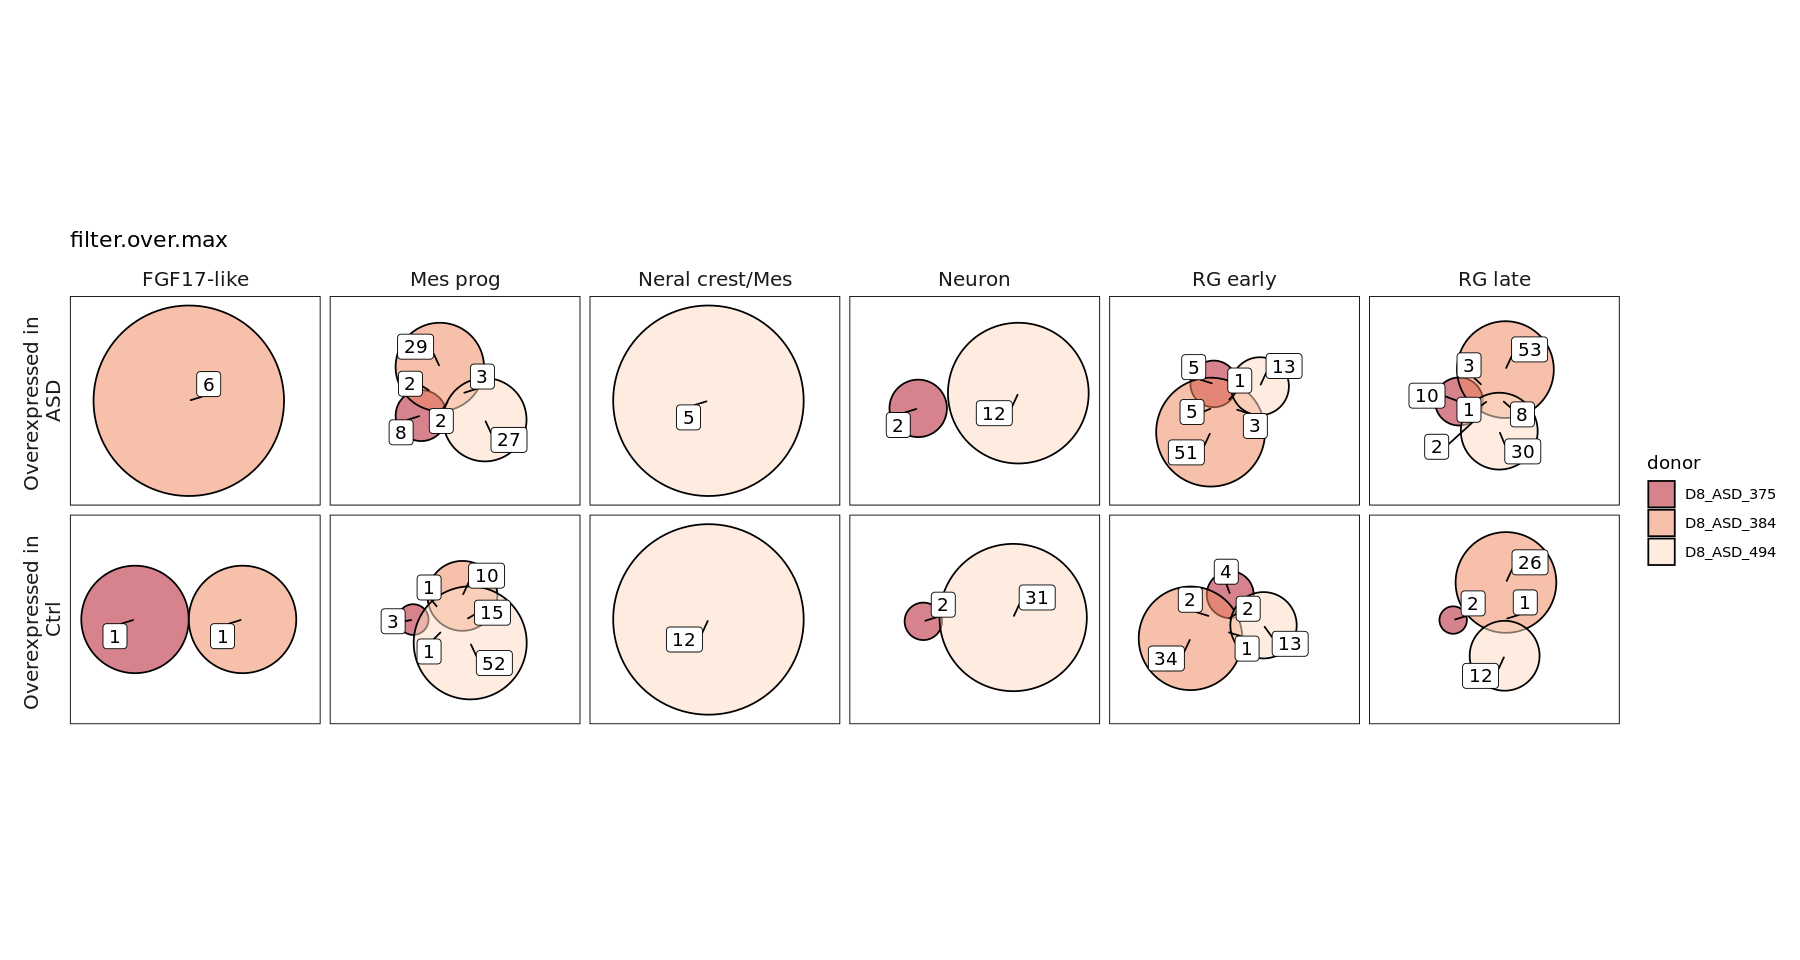

In [92]:
dir.create('../plots/venn_donors/')
# pdf('../plots/venn_donors/venn_diagrams_across_celltypes.pdf', width=15, height=8)
for (filt in c('filter.over.max')){
    filt.dat <- crossed.res[crossed.res[, filt],] %>% mutate(donor=factor(as.character(donor), donors))
    bias_ct_donor.markers <- split(filt.dat,
                                   apply(filt.dat[c('overexpressed.in', 'anno_cluster_fct')], 1, paste, collapse='...'))
    cir.ints <- lapply(names(bias_ct_donor.markers), function(x){
        get.intersection.circles(split(bias_ct_donor.markers[[x]]$gene, 
                                       bias_ct_donor.markers[[x]]$donor)) -> dat

        if (is.null(dat)){return(dat)}
        strsplit(x, split='...', fixed=T)[[1]] -> bias.ct
        dat$circles %>% mutate(overexpressed.in=bias.ct[1], anno_cluster_fct=bias.ct[2], donor=rownames(dat))-> dat$circles
        dat$intersections %>% mutate(overexpressed.in=bias.ct[1], anno_cluster_fct=bias.ct[2], donor=rownames(dat))->dat$intersections
        dat

    })
    
    lapply(cir.ints, function(x){x$circles}) %>% do.call(what='rbind') %>% as.data.frame() %>% mutate(donor=factor(as.character(labels), donors))-> circles.df 
    lapply(cir.ints, function(x){x$intersections}) %>% do.call(what='rbind') %>% as.data.frame()-> inters.df 
    
    polygon_df <- circles_to_polygons(circles.df) %>% mutate(donor=factor(as.character(labels), donors))
    
    p <- ggplot(polygon_df,
       aes(x,y)) + 
    geom_polygon(aes(fill=donor), color='black')+
    scale_fill_manual(values=donors.pal)+
    facet_grid2(cols = vars(anno_cluster_fct), rows = vars(paste('Overexpressed in ', overexpressed.in, sep='\n')), switch='y') + 
    coord_equal() + theme_minimal() + 
    labs(x=NULL, y=NULL) +
    geom_label_repel(
    # geom_text(
        # force_pull = -.1,
        min.segment.length = 0,
        data=inters.df, 
        alpha=1,
        aes(centers.x, centers.y, 
            # fill=donor,
            label = ifelse(set.size!=0, set.size, NA))) + 
    theme(
        panel.background = element_rect(color='black'),
        strip.text = element_text(size=12), 
        panel.grid = element_blank(), 
        axis.ticks = element_blank(),
        axis.text = element_blank()) + 
    ggtitle(filt)
    
    plot(p)
    stop() 
   
    
}
# dev.off()


### Upset of intersections

In [530]:
n.genes.row <- 100

In [531]:
library(UpSetR)
library(plyr)

for (filt in c('filter.padj')){
# for (filt in c('filter.padj', 'filter.padj.top100', 'filter.pval.top100')){

    filt.dat <- filt.res.donors[filt.res.donors[, filt],] %>% mutate(donor=factor(as.character(donor), donors))
    
    bias_ct_donor.markers <- split(filt.dat,
                                   apply(filt.dat[c('overexpressed.in', 'anno_cluster_fct')], 1, paste, collapse='...')) %>% 
        lapply(function(x){split(x$gene, x$donor) %>% lapply(unique)})
    
#     bias_ct_donor.markers <- c(
#         bias_ct_donor.markers,
#         split(filt.dat, filt.dat$overexpressed.in))
    
    # all.int.texts <- list()
    all.int.sizes <- list()
    for (x in names(bias_ct_donor.markers)){
        
        message(x)
        donor.gene.split <- bias_ct_donor.markers[[x]]
        
        if (sum(sapply(donor.gene.split, length)!=0)>1){
            us.plot <- upset(fromList(donor.gene.split), order.by = "degree")
        }
        
        int.tbl <- get_presence_table(donor.gene.split)
        int.df <- get_intersections(int.tbl, return.as='data.frame')
        # int.texts <- get_interextion_text_df(int.df, 60)
        int.sizes <- data.frame(table(int.df$int.stat))
        rownames(int.sizes) <- int.sizes$Var1
        int.sizes$Var1 <- NULL
        int.sizes <- t(int.sizes)
        all.int.sizes[[x]] <- data.frame(int.sizes) %>% mutate(compared.group=x)
        # all.int.texts[[x]] <- data.frame(int.texts) %>% mutate(compared.group=x)
        
    }
    # all.int.texts <- do.call(what='rbind.fill', all.int.texts)
    all.int.sizes <- do.call(what='rbind.fill', all.int.sizes)
    all.int.sizes[is.na(all.int.sizes)] <- 0
}


ASD...FGF17-like

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
ASD...Mes prog

ASD...Neral crest/Mes

ASD...Neuron

ASD...RG early

ASD...RG late

Ctrl...FGF17-like

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
Ctrl...Mes prog

Ctrl...Neral crest/Mes

Ctrl...Neuron

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
Ctrl...RG early

Ctrl...RG late



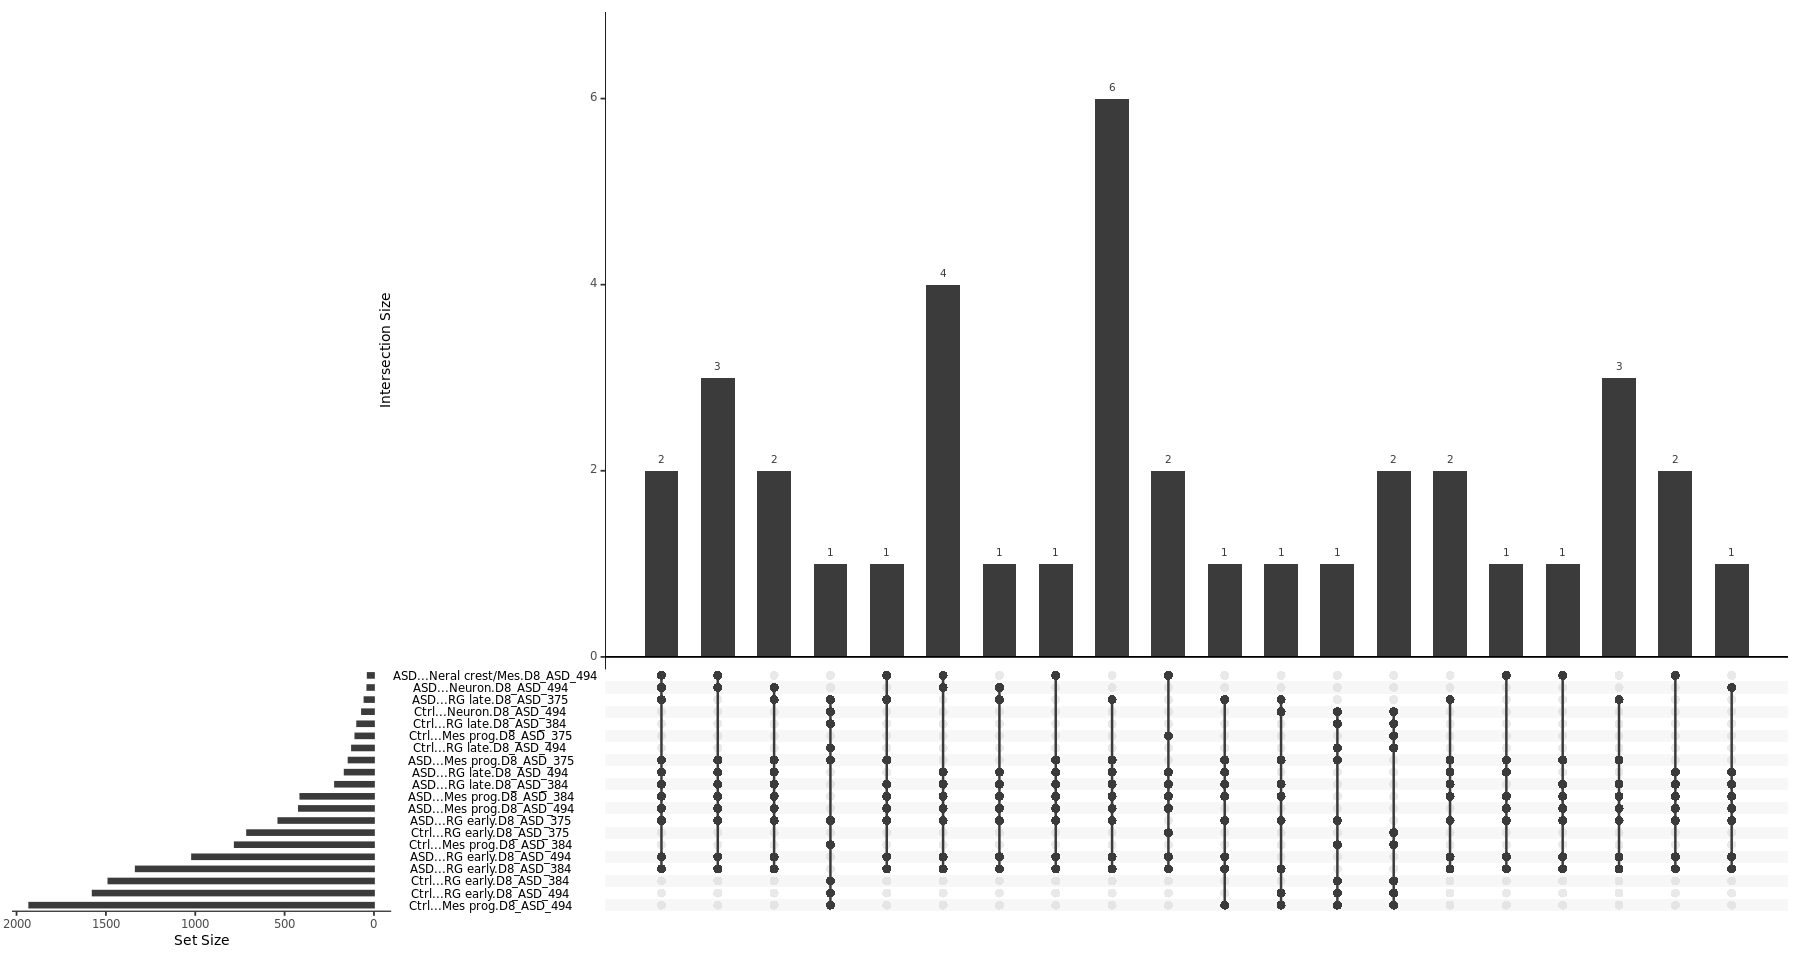

In [487]:
upset(fromList(unlist(bias_ct_donor.markers, recursive = F)), nsets = 20, nintersects = 20, order.by = 'degree' )

$`ASD...FGF17-like.D8_ASD_375`
character(0)

$`ASD...FGF17-like.D8_ASD_384`
[1] "CSRP2" "FGF8"  "FZD5"  "SFRP1" "SIX3"  "SPRY1"

$`ASD...FGF17-like.D8_ASD_494`
[1] "RPL28" "RPS11" "RPS15"

$`ASD...Mes prog.D8_ASD_375`
  [1] "ACTA1"           "ACTA2"           "AKAP17A"         "APRT"           
  [5] "ARL17B"          "BBS9"            "BST2"            "CALD1"          
  [9] "CALM1"           "CARHSP1"         "CCDC152"         "CD99"           
 [13] "CEBPZOS"         "CLDN6"           "CLN8-AS1"        "COL11A1"        
 [17] "COMMD6"          "COTL1"           "CPNE1"           "CSRP2"          
 [21] "DDX3Y"           "DHFR"            "DSP"             "EIF1AY"         
 [25] "EMC9"            "ENSG00000250284" "ENSG00000289474" "FAAP20"         
 [29] "FAT1"            "FBLN1"           "FJX1"            "FRZB"           
 [33] "FTL"             "FZD5"            "H1-1"            "H2AZ1"          
 [37] "HES4"            "HLA-DPB1"        "HMGA1"           "HPDL"           
 [41] "HSPA1A"          "ID2"             "IGFBP5"          "JUND"           
 [45] "KANSL1-AS1"      "KDM5D"           "KRT19"           "KRT8"           
 [49] "LDHA"            "LGALS1"          "LHX2"            "LHX2-AS1"       
 [53] "LIM2"            "LIMA1"           "LINC01515"       "LIX1"           
 [57] "MAP3K13"         "MEG3"            "MEG8"            "MGMT"           
 [61] "MYH9"            "MYL6"            "MYL9"            "NACA"           
 [65] "NAPRT"           "NDUFS5"          "NLGN4Y"          "NRP2"           
 [69] "NUDT14"          "PAMR1"           "PCLAF"           "PKIB"           
 [73] "POLR2H"          "PTMS"            "PTPRZ1"          "PURPL"          
 [77] "RAB11FIP1"       "RPA3"            "RPL10"           "RPL10A"         
 [81] "RPL11"           "RPL12"           "RPL13A"          "RPL14"          
 [85] "RPL15"           "RPL17"           "RPL18"           "RPL18A"         
 [89] "RPL22L1"         "RPL24"           "RPL26"           "RPL29"          
 [93] "RPL3"            "RPL5"            "RPL7A"           "RPS14"          
 [97] "RPS17"           "RPS18"           "RPS19"           "RPS2"           
[101] "RPS20"           "RPS27L"          "RPS3"            "RPS4X"          
[105] "RPS4Y1"          "RPS7"            "RPS9"            "RRAS"           
[109] "S100A4"          "S100A6"          "SELENOW"         "SEMA6A"         
[113] "SH3BGR"          "STC2"            "TAF13"           "TAGLN"          
[117] "TCEAL7"          "THNSL2"          "THUMPD3"         "TIMM10"         
[121] "TMSB15A"         "TMSB4Y"          "TNNT1"           "TP53"           
[125] "TPM1"            "TRIM26"          "TRIM61"          "TTN-AS1"        
[129] "TTTY14"          "TULP1"           "TXNIP"           "UBXN4"          
[133] "UPP1"            "USP9Y"           "UTY"             "UVSSA"          
[137] "XRRA1"           "ZCRB1"           "ZFY"             "ZNF528"         
[141] "ZNF528-AS1"      "ZNF544"         

$`ASD...Mes prog.D8_ASD_384`
  [1] "ABHD14A"         "ACTA1"           "ACTA2"           "ACTN4"          
  [5] "ADAMTS6"         "ADGRL3"          "ANKRD35"         "AP2S1"          
  [9] "APLP2"           "APOBEC3C"        "ARGLU1"          "ARHGAP29"       
 [13] "ARL17B"          "ARL4C"           "ARL6IP4"         "ASMTL"          
 [17] "ATF3"            "ATF4"            "ATOH8"           "ATP1A2"         
 [21] "B3GALT1"         "BBC3"            "BBLN"            "BCL2L11"        
 [25] "BEGAIN"          "BGLAP"           "C12orf57"        "C1orf21"        
 [29] "CABLES1"         "CADM3"           "CALD1"           "CALM1"          
 [33] "CARHSP1"         "CAVIN1"          "CCDC107"         "CCDC152"        
 [37] "CCK"             "CCND1"           "CCND2"           "CD151"          
 [41] "CD24"            "CD81"            "CD99"            "CDH11"          
 [45] "CDH4"            "CDON"            "CEBPZOS"         "CFL1"           
 [49] "CHAC1"           "CHCHD2"          "C

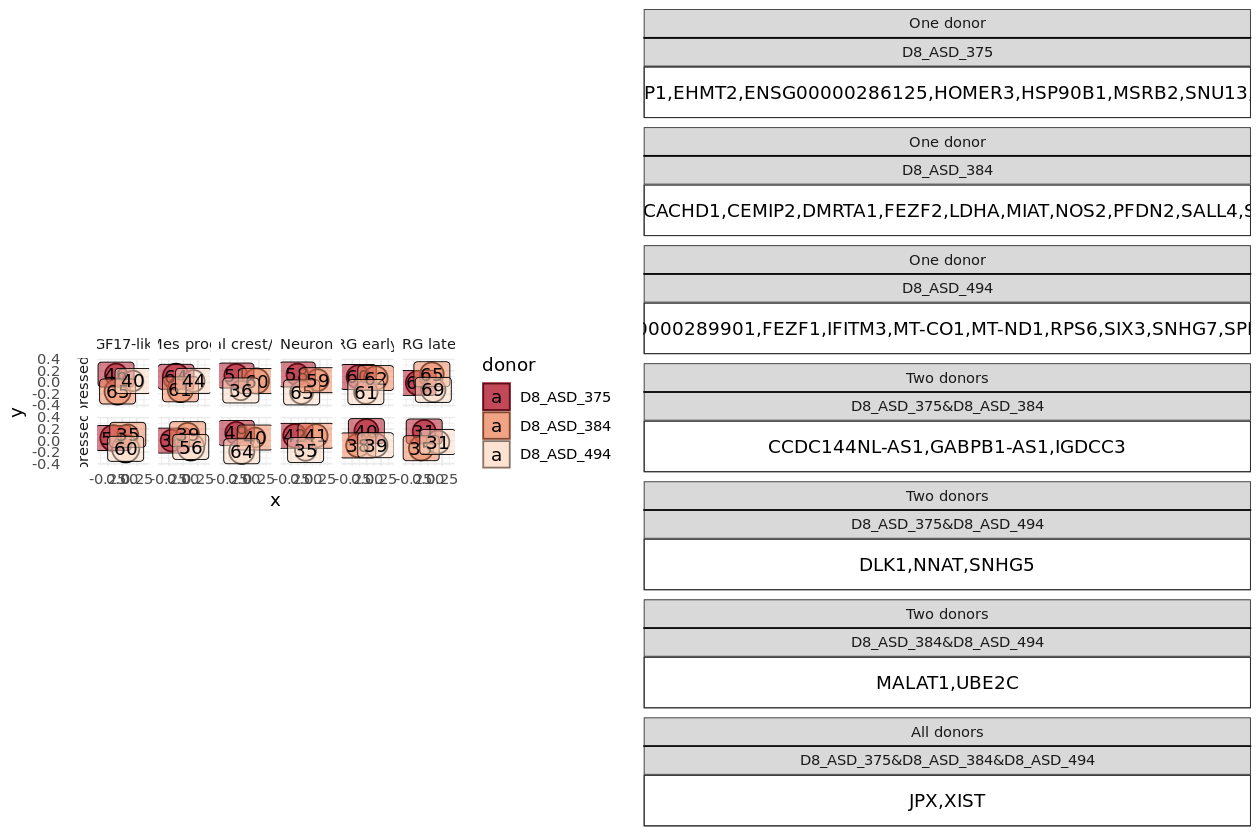

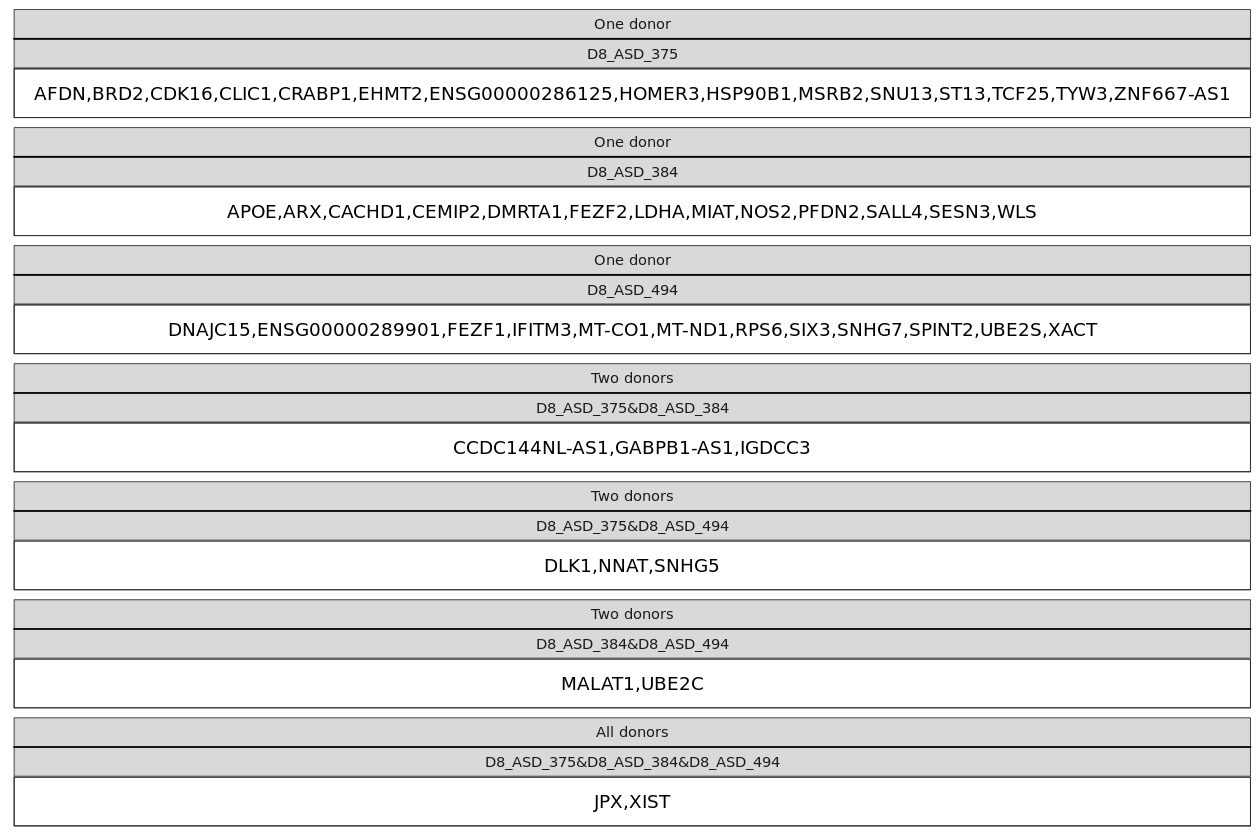

In [391]:
cowplot::plot_grid(
    p, int.tblplot
)
